In [4]:
#Five fold cross validation


import numpy as np
import pyedflib
from matplotlib import pyplot as plt
from nitime import utils
from nitime import algorithms as alg
from nitime.timeseries import TimeSeries
from nitime.viz import plot_tseries
import csv
import pywt
import scipy.stats as sp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import signal
from spectrum import *
from os import listdir
from os.path import isfile, join
from wyrm import processing as proc
from wyrm.types import Data
from wyrm.io import convert_mushu_data
from sklearn import metrics
from wyrm.processing import calculate_csp,segment_dat,apply_csp,append_epo
from wyrm.processing import select_channels
from wyrm.processing import swapaxes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.preprocessing import normalize

In [5]:
files1  = [f for f in listdir('/home/singh/projects/BCI/binary/Training data')]


channels = ['Fp1', 'AFp1', 'Fpz', 'AFp2', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'FAF5', 'FAF1', 'FAF2', 'FAF6', 
                'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FFC7', 'FFC5', 'FFC3', 'FFC1', 'FFC2', 'FFC4', 
                'FFC6', 'FFC8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'CFC7', 
                'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6'
                , 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1',
                'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'PCP7', 'PCP5', 'PCP3', 'PCP1', 'PCP2', 'PCP4', 'PCP6', 'PCP8', 
                'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PPO7', 'PPO5', 'PPO1', 'PPO2', 'PPO6',
                'PPO8', 'PO7', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO8', 'OPO1', 'OPO2', 'O1', 'Oz', 'O2', 'OI1', 'OI2', 
                'I1', 'I2']

In [6]:
files1

['ay', 'aw', 'aa', 'al', 'av']

In [7]:
#for 1st subject
sub = 1
training_data = '/home/singh/projects/BCI/binary/Training data/' + files1[sub] + '/data_set_IVa_' + files1[sub] + '_cnt.txt'
markers       = '/home/singh/projects/BCI/binary/Training data/' + files1[sub] + '/data_set_IVa_' + files1[sub] + '_mrk.txt'
    
signal_array = [map(float,l.split()) for l in open(training_data).readlines()]
    
signal_array = np.array(signal_array)
    
marker_array = [map(str,l.split()) for l in open(markers).readlines()]
        
time = np.arange(len(signal_array))
    
train_markers1 = [(float(events[0]),str(events[1])) for events in marker_array if events[1]!= 0]


for events in marker_array:
    if events[1] != 0:
        train_markers1.append((float(events[0]) + 50.0, str(events[1])))
        train_markers1.append((float(events[0]) + 100.0, str(events[1])))
        train_markers1.append((float(events[0]) + 150.0, str(events[1])))
        train_markers1.append((float(events[0]) + 200.0, str(events[1])))
        train_markers1.append((float(events[0]) + 250.0, str(events[1])))
        train_markers1.append((float(events[0]) + 300.0, str(events[1])))
        train_markers1.append((float(events[0]) + 350.0, str(events[1])))

markers1 = np.array(train_markers1)

y1 = [0] * len(markers1)


markers_subject1_class_1 = [(float(events[0]),str(events[1])) for events in markers1 if events[1]== '1']
markers_subject1_class_2 = [(float(events[0]),str(events[1])) for events in markers1 if events[1]== '2']


cnt1 = convert_mushu_data(signal_array, markers_subject1_class_1,50,channels)
cnt2 = convert_mushu_data(signal_array, markers_subject1_class_2,50,channels)
    
md = {'class 1': ['1'],'class 2': ['2']}
    
epoch_subject1_class1 = segment_dat(cnt1, md, [0, 1000])
epoch_subject1_class2 = segment_dat(cnt2, md, [0, 1000])


In [8]:
# Appending all the different subject training epochs

final_epoch = append_epo(epoch_subject1_class1,epoch_subject1_class2)


In [9]:
print (final_epoch.data.shape)

(448, 50, 118)


In [10]:
####### FUNCTION TO FIND BAND POWERS ###########

def bandpowers(segment):
    features = []
    for i in range(len(segment)):
        f,Psd = signal.welch(segment[i,:], 100)
        power1 = 0
        power2 = 0
        f1 = []
        for j in range(0,len(f)):
            if(f[j]>=4 and f[j]<=13):
                power1 += Psd[j]
            if(f[j]>=14 and f[j]<=30):
                power2 += Psd[j]
        features.append(power1)
        features.append(power2)
    return features

In [11]:
######### Discrete Cosine Transform
from scipy.fftpack import fft, dct
def dct_features(segment):
    features = []
    for i in range(len(segment)):
        dct_coef = dct(segment[i,:], 2, norm='ortho')
        power = sum( j*j for j in dct_coef)
        features.append(power)
    return features

In [12]:
####### FUNCTION TO FIND WAVELET FEATURES#######

def wavelet_features(epoch):
    cA_values = []
    cD_values = []
    cA_mean = []
    cA_std = []
    cA_Energy =[]
    cD_mean = []
    cD_std = []
    cD_Energy = []
    Entropy_D = []
    Entropy_A = []
    features = []
    for i in range(len(epoch)):
        cA,cD=pywt.dwt(epoch[i,:],'coif1')
        cA_values.append(cA)
        cD_values.append(cD)		#calculating the coefficients of wavelet transform.
    for x in range(len(epoch)):   
        cA_Energy.append(abs(np.sum(np.square(cA_values[x]))))
        features.append(abs(np.sum(np.square(cA_values[x]))))
        
    for x in range(len(epoch)):      
        cD_Energy.append(abs(np.sum(np.square(cD_values[x]))))
        features.append(abs(np.sum(np.square(cD_values[x]))))
        
    return features

In [13]:
## FULL FEATURES DICTIONARY

# Dictionary with band power features
#form the dictionary using bandpower features where each column is a data point.

#For class 1
dictionary1 = []
dictionary2 = []
dictionary3 = []
for i in range(len(final_epoch.axes[0])):
    segment = final_epoch.data[i]
    segment = np.array(segment)
    segment = np.transpose(segment)
    
   
    features1 = bandpowers(segment)  ## Comment the dictionaries not used
    #features = logvariance(segment)
    
    features2 = wavelet_features(segment)
    features3 = dct_features(segment)
    
    dictionary1.append(features1)
    dictionary2.append(features2)
    dictionary3.append(features3)
    
    
dictionary1 = np.array(dictionary1)
dictionary2 = np.array(dictionary2)
dictionary3 = np.array(dictionary3)



dictionary_bandpower  = dictionary1
dictionary_wavelet = dictionary2
dictionary_dct = dictionary3


targets = final_epoch.axes[0]





/home/singh/miniconda3/envs/data2/lib/python2.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  .format(nperseg, input_length))


In [14]:
dictionary_wavelet.shape

(448, 236)

In [15]:
#FOr wavelet

from scipy.sparse import coo_matrix
X_sparse = coo_matrix(dictionary_wavelet)

from sklearn.utils import resample
dictionary_wavelet, X_sparse, ywe = resample(dictionary_wavelet, X_sparse,targets , random_state=0)

In [16]:
#For Band Power

from scipy.sparse import coo_matrix
X_sparse = coo_matrix(dictionary_bandpower)

from sklearn.utils import resample
dictionary_bandpower, X_sparse, ybp = resample(dictionary_bandpower, X_sparse,targets , random_state=0)

In [17]:
#For DCT

from scipy.sparse import coo_matrix
X_sparse = coo_matrix(dictionary_dct)

from sklearn.utils import resample
dictionary_dct, X_sparse, y = resample(dictionary_dct, X_sparse,targets , random_state=0)

In [18]:
from sklearn.model_selection import KFold

#dictionary = dictionary_bandpower
dictionary = dictionary_wavelet
#dictionary = dictionary_dct

kf = KFold(n_splits=10,random_state = 30, shuffle = True)
kf.get_n_splits(dictionary)

y_classifier1 = []
y_classifier2 = []
y_classifier3 = []
y_classifier4 = []


y_all1 = []
y_all2 = []
y_all3 = []
y_all4 = []
y_example_test = []

print(kf)



y_final_test = []

KFold(n_splits=10, random_state=30, shuffle=True)


In [19]:

def calculate_accuracy(Xts,yts,D,class1,class2,n):
    y_pred1 = []
    y_pred2 = []
    y_pred3 = []
    y_pred4 = []
    diff = []
    counter1 = 0
    counter2 = 0
    
    sigma_1 = metrics.pairwise.euclidean_distances(dictionary_wavelet.transpose())
    sigma = np.sum(sigma_1)/((dictionary_wavelet.shape[1])*(dictionary_wavelet.shape[1]))
    
    for i in range(len(Xts)):
        features = Xts[i]
        
        # Find Eucledian distance between single test case with all atoms 
        # in dictionary and store in vector(Weights) of size equal to number of test cases.
        Weights = np.zeros((D.shape[1],))
        #for j in range(D.shape[1]):
         #   Weights[j] = spatial.distance.euclidean(features, D.transpose()[j])
        
        Weights = metrics.pairwise.euclidean_distances(D.transpose(), features.reshape(1,-1)).flatten()
        
        # Apply formula w_i = exp(-1*dist(y,d_i)/sigma) on vector, elementwise.
        # Subtract from maximum to normalize.
        weights = np.exp(-1*Weights/sigma)
        weights = np.amax(weights) - weights
        
        # Get new weighted dictionary by multiplying weights to D.
        D_dash = (D)*weights
        
        # Apply OMP with new dictionary (using old code)
        omp = OrthogonalMatchingPursuit(n_nonzero_coefs=3)
        omp.fit(D_dash,features)
        coef = omp.coef_
        
        p = 0
        q = 0
        l = 0
        m = 0
        a = 0
        b = 0
        
                
        list1 = coef[0:min(class1,class2)]
        list2 = coef[min(class1,class2)+1:2*min(class1,class2)]
        
        c1 = (sum(z*z for z in list1))**(1/2.0) 
        c2 = (sum(z*z for z in list2))**(1/2.0) 
        
        p = np.std(list1)
        q = np.std(list2)
        
        a = max(list1)
        b = max(list2)
        
        for ko in range(min(class1,class2)):
            l = l + coef[ko]
        
        for io in xrange(min(class1,class2)+1,2*min(class1,class2)):
            m = m + coef[io]
            
        if p > q:
            y_pred1.append(0)
          
        else:
            y_pred1.append(1)
            if(yts[i] != 0):
                if(counter1==0):
                    counter1 +=1
                    idx_r, = coef.nonzero()
                    #plt.xlim(0, len(coef))
                    #plt.title("Sparse Signal")
                    #plt.stem(idx_r, coef[idx_r])
                    #plt.show()
            
        if l>m:
            y_pred2.append(0)
        else:
            y_pred2.append(1)
        
        if a>b:
            y_pred3.append(0)
        else:
            y_pred3.append(1)
            
        if c1 > c2:
            y_pred4.append(0)
        else:
            y_pred4.append(1)
            
    p1 = metrics.accuracy_score(yts, y_pred4, normalize=True, sample_weight=None)
    p2 = metrics.accuracy_score(yts, y_pred3, normalize=True, sample_weight=None)
    p3 = metrics.accuracy_score(yts, y_pred1, normalize=True, sample_weight=None)
    p4 = metrics.accuracy_score(yts, y_pred2, normalize=True, sample_weight=None)
    print('class1', p1)  
    
    print('class2', p2) 
    
    print('class3', p3)
    
    print('class4', p4)
    
    print('\n')
    
    
    return y_pred4,y_pred3,y_pred1,y_pred2, p1, p2, p3, p4
    



In [27]:
## K fold cross validation
import time
from sklearn.model_selection import KFold

#dictionary = dictionary_bandpower
dictionary = dictionary_wavelet
#dictionary = dictionary_dct

kf = KFold(n_splits=10, random_state=10, shuffle=True)
kf.get_n_splits(dictionary)

y_classifier1 = []
y_classifier2 = []
y_classifier3 = []
y_classifier4 = []

y_all1 = []
y_all2 = []
y_all3 = []
y_all4 = []
y_example_test = []

psum1 = 0
psum2 = 0
psum3 = 0
psum4 = 0

y_final_test = []

print(kf)

start_time = time.time()

for train_index, test_index in kf.split(dictionary):
    X_train, X_test = dictionary[train_index], dictionary[test_index]
    y_train, y_test = ywe[train_index], ywe[test_index]
    class1 = 0
    class2 = 0
    for i in range(len(y_train)):
        if (y_train[i] == 0):
            class1 += 1
        else:
            class2 += 1
    reb_y = []
    reb_dic = []
    count = 0
    iterator = 0
    while (count < min(class1, class2)):
        if y_train[iterator] == 0:
            reb_dic.append(X_train[iterator])
            reb_y.append(0)
            count += 1
        iterator += 1

    count = 0
    iterator = 0
    while (count < min(class1, class2)):
        if y_train[iterator] == 1:
            reb_dic.append(X_train[iterator])
            reb_y.append(1)
            count += 1
        iterator += 1
    reb_dictionary = np.array(reb_dic)
    reb_dictionary = reb_dictionary.transpose()
    y_classifier1, y_classifier2, y_classifier3, y_classifier4, p1, p2, p3, p4 = calculate_accuracy(
        X_test, y_test, reb_dictionary, class1, class2, 5)
    psum1 = psum1 + p1
    psum2 = psum2 + p2
    psum3 = psum3 + p3
    psum4 = psum4 + p4

    y_all1.extend(y_classifier1)
    y_all2.extend(y_classifier2)
    y_all3.extend(y_classifier3)
    y_all4.extend(y_classifier4)

    y_final_test.extend(y_test)
    y_example_test = y_test
print('class1_avg', psum1/10.0)
print('class2_avg', psum2/10.0)
print('class3_avg', psum3/10.0)
print('class4_avg', psum4/10.0)
print("--- %s seconds ---" % (time.time() - start_time))

KFold(n_splits=10, random_state=10, shuffle=True)
('class1', 0.97777777777777775)
('class2', 0.97777777777777775)
('class3', 0.97777777777777775)
('class4', 0.97777777777777775)


('class1', 0.91111111111111109)
('class2', 0.91111111111111109)
('class3', 0.91111111111111109)
('class4', 0.91111111111111109)


('class1', 0.91111111111111109)
('class2', 0.91111111111111109)
('class3', 0.91111111111111109)
('class4', 0.91111111111111109)


('class1', 1.0)
('class2', 1.0)
('class3', 1.0)
('class4', 1.0)


('class1', 0.97777777777777775)
('class2', 0.97777777777777775)
('class3', 0.97777777777777775)
('class4', 0.97777777777777775)


('class1', 0.9555555555555556)
('class2', 0.9555555555555556)
('class3', 0.9555555555555556)
('class4', 0.9555555555555556)


('class1', 0.9555555555555556)
('class2', 0.9555555555555556)
('class3', 0.9555555555555556)
('class4', 0.9555555555555556)


('class1', 0.97777777777777775)
('class2', 0.97777777777777775)
('class3', 0.97777777777777775)
('class4', 0.977

In [29]:
# Test case running time for 1 test case
start_time = time.time()
y_classifier1,y_classifier2,y_classifier3,y_classifier4 ,a1,a2,a3,a4= calculate_accuracy(np.reshape(X_test[0],(1,-1)), np.reshape(y_test[0],(1,-1)),reb_dictionary,class1,class2,5)
print("--- %s seconds ---" % (time.time() - start_time))

('class1', 1.0)
('class2', 1.0)
('class3', 1.0)
('class4', 1.0)


--- 0.00800108909607 seconds ---


In [62]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[645   2]
 [  4 693]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.01  0.99]]


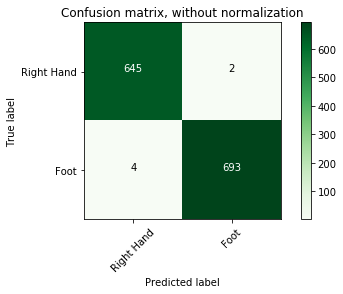

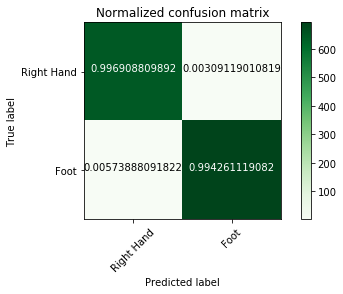

In [63]:
##PLOT CONFUSION MATRIX
cnf_matrix = confusion_matrix(y_final_test, y_all3)
np.set_printoptions(precision=2)
class_names = ["Right Hand","Foot"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

In [64]:
#calculate score
from sklearn.metrics import f1_score
y_score = f1_score(y_final_test, y_all1, average=None)

In [65]:
y_score

array([ 1.,  1.])

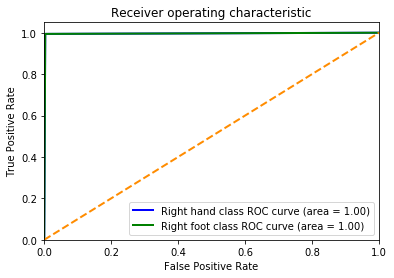

In [66]:
## Plot ROC curve

count = 0
iterator = 0
real0 = []
pred0 = []

real1 = []
pred1 = []


real2 = []
pred2 = []


real3 = []
pred3 = []

while(iterator < len(y_final_test)):
    if(y_final_test[iterator] == 0):
        real0.append(0)
        if(y_all1[iterator] == 0):
            pred0.append(0)
        else:
            pred0.append(1)
    else:
        real0.append(1)
        if(y_all1[iterator] == 0):
            pred0.append(0)
        else:
            pred0.append(1)
    iterator += 1
    
iterator = 0
while(iterator < len(y_final_test)):
    if(y_final_test[iterator] == 1):
        real1.append(1)
        if(y_all1[iterator] == 1):
            pred1.append(1)
        else:
            pred1.append(0)
    else:
        real1.append(0)
        if(y_all1[iterator] == 1):
            pred1.append(1)
        else:
            pred1.append(0)
    iterator += 1
    
    


import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

fpr, tpr, _ = roc_curve(real0, pred0)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(real1, pred1)
roc_auc1 = auc(fpr1, tpr1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='blue',
         lw=lw, label='Right hand class ROC curve (area = %0.2f)' % roc_auc)

plt.plot(fpr1, tpr1, color='green',
         lw=lw, label='Right foot class ROC curve (area = %0.2f)' % roc_auc1)

plt.plot([0, 1], [0, 1], color='darkorange', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

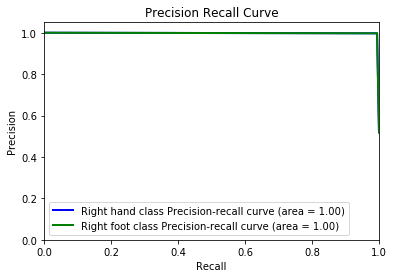

In [67]:
## Plot precision recall curve

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# Compute Precision-Recall and plot curve
precision = []
recall = []
average_precision = []

precision, recall,thresholds = precision_recall_curve(real0,pred0)

average_precision = average_precision_score(real0,pred0)


precision1, recall1,thresholds1 = precision_recall_curve(real1,pred1)

average_precision1 = average_precision_score(real1,pred1)


# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=lw, color='blue', label='Right hand class Precision-recall curve (area = {0:0.2f})'
                   ''.format(average_precision))

plt.plot(recall1, precision1, lw=lw, color='green', label='Right foot class Precision-recall curve (area = {0:0.2f})'
                   ''.format(average_precision1))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision Recall Curve")

plt.legend(loc="lower left")
plt.show()
